[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/research-assistant.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239974-lesson-4-research-assistant)

# Research Assistant

## Review

We've covered a few major LangGraph themes:

* Memory
* Human-in-the-loop
* Controllability

##### Now, we'll bring these ideas together to tackle one of AI's most popular applications: research automation. 

Research is often laborious work offloaded to analysts. AI has considerable potential to assist with this.

However, **research demands customization: raw LLM outputs are often poorly suited for real-world decision-making workflows.** 

##### Customized, AI-based [research and report generation](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/#reports-over-rag) workflows are a promising way to address this.

## Goal

##### Our goal is to build a lightweight, multi-agent system around chat models that customizes the research process.

`Source Selection` 
* Users can choose any set of input sources for their research.
  
`Planning` 
* Users provide a topic, which we'll break it up into a set of sub-topics. Then, the system generates a team of AI analysts, each focusing on one sub-topic.
* `Human-in-the-loop` will be used to refine these sub-topics before research begins.
  
`LLM Utilization`
* Each analyst will conduct in-depth interviews with an expert AI using the selected sources.
> Orchestration of a dialog between each analyst and an expert that has access to the sources. -> AI-AI roleplay
* The interview will be a multi-turn conversation to extract detailed insights as shown in the [STORM](https://arxiv.org/abs/2402.14207) paper.
* These interviews will be captured in a using `sub-graphs` with their internal state. 
   
`Research Process`
* Experts will gather information to answer analyst questions in `parallel`.
* And all interviews will be conducted simultaneously through `map-reduce`.

`Output Format` 
* The gathered insights from each interview will be synthesized into a final report.
* We'll use customizable prompts for the report, allowing for a flexible output format. 

![Screenshot 2024-08-26 at 7.26.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb164d61c93d48e604091_research-assistant1.png)

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python wikipedia

## Setup

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [4]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0) 

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Generate Analysts: Human-In-The-Loop

##### First graph to generate the analysts and review them using human-in-the-loop.

In [ ]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel): # Analyst model that standardizes all analysts characteristics
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    # @property lets you access a method like a read-only attribute, so analyst.persona returns a formatted string without needing analyst.persona()
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel): # for structed output. This is the list of analysts
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class GenerateAnalystsState(TypedDict): # Analyst Generation Graph State
    topic: str # The Overall Research topic
    max_analysts: int # Number of analysts to generate (also the sub-topics, as 1 analyst = 1 sub-topic)
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analysts asking questions

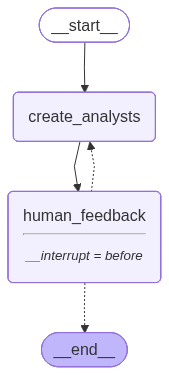

In [ ]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

# node 1
def create_analysts(state: GenerateAnalystsState):
    
    """ Create analysts """
    
    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')
        
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(topic=topic,
                                                            human_analyst_feedback=human_analyst_feedback, 
                                                            max_analysts=max_analysts)

    # HumanMessage: Generate analysts question to kick off the chain
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

# Node 2 - No-op for human feedback
def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

# conditional edge
# is there a human feedback in the state? yes -> go back to creat_analysts and generate 
# based upon the feedback. no -> end analyst generation
def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    
    # Otherwise end
    return END

# Add nodes and edges 
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

#### This is phase 1 of research: Make sure the scope is set correctly before do all the work.

##### Human feedback does that by reviewing the generated team.

## Executing Analyst Generation

In [ ]:
# Input
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"

# define thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph (until the first interruption)
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Innovations Inc.
Role: AI Framework Specialist
Description: Dr. Carter focuses on the technical advantages of adopting LangGraph, emphasizing its scalability and integration capabilities with existing systems. She is motivated by the potential for LangGraph to enhance AI-driven solutions in various industries.
--------------------------------------------------
Name: Mr. James Liu
Affiliation: Data Science Research Group
Role: Data Analyst
Description: Mr. Liu analyzes the impact of LangGraph on data processing efficiency and accuracy. His work is driven by a desire to improve data-driven decision-making processes and to showcase how LangGraph can streamline workflows in data-intensive environments.
--------------------------------------------------
Name: Ms. Sarah Thompson
Affiliation: Business Strategy Consultants
Role: Business Development Analyst
Description: Ms. Thompson evaluates the business implications of adopting LangGraph, focusing on 

In [ ]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

## As expected, we're waiting on human feedback.

('human_feedback',)

In [9]:
# We now update the state as if we are the human_feedback node
# hardcoding a human feedback for the demo
graph.update_state(thread, {"human_analyst_feedback": 
                            "Add in someone from a startup to add an entrepreneur perspective"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f09bad4-e17e-6253-8002-1c7743432867'}}

In [ ]:
# Continue the graph execution (pass None)
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

### 3 new analysts added based upon the human feedback.

Name: Dr. Emily Carter
Affiliation: Tech Innovations Inc.
Role: AI Framework Specialist
Description: Dr. Carter focuses on the technical advantages of adopting LangGraph, emphasizing its scalability and integration capabilities with existing systems. She is motivated by the potential for LangGraph to enhance AI-driven solutions in various industries.
--------------------------------------------------
Name: Mr. James Liu
Affiliation: Data Science Research Group
Role: Data Analyst
Description: Mr. Liu analyzes the impact of LangGraph on data processing efficiency and accuracy. His work is driven by a desire to improve data-driven decision-making processes and to showcase how LangGraph can streamline workflows in data-intensive environments.
--------------------------------------------------
Name: Ms. Sarah Thompson
Affiliation: Business Strategy Consultants
Role: Business Development Analyst
Description: Ms. Thompson evaluates the business implications of adopting LangGraph, focusing on 

In [11]:
# If we are satisfied, then we simply supply no feedback (pass None)
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f09bad8-38da-6449-8004-067bd8ca45d2'}}

In [12]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [13]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')
analysts

[Analyst(affiliation='Tech Startup Incubator', name='Jordan Lee', role='Startup Founder', description='Jordan is the founder of a tech startup focused on AI solutions. They are interested in how LangGraph can streamline development processes and enhance product offerings, particularly in the context of limited resources and rapid iteration.'),
 Analyst(affiliation='AI Research Institute', name='Dr. Emily Chen', role='AI Researcher', description='Dr. Chen is a leading researcher in AI frameworks and their applications. She focuses on the technical advantages of LangGraph, including its scalability and integration capabilities, and how these can benefit both academic and commercial projects.'),
 Analyst(affiliation='Enterprise Software Company', name='Michael Thompson', role='Product Manager', description='Michael works as a product manager at a large enterprise software company. He is concerned with the practical implementation of LangGraph in existing systems, its impact on team collab

In [ ]:
final_state.next

## Graph is done, no next node to execute.

()

In [15]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Jordan Lee
Affiliation: Tech Startup Incubator
Role: Startup Founder
Description: Jordan is the founder of a tech startup focused on AI solutions. They are interested in how LangGraph can streamline development processes and enhance product offerings, particularly in the context of limited resources and rapid iteration.
--------------------------------------------------
Name: Dr. Emily Chen
Affiliation: AI Research Institute
Role: AI Researcher
Description: Dr. Chen is a leading researcher in AI frameworks and their applications. She focuses on the technical advantages of LangGraph, including its scalability and integration capabilities, and how these can benefit both academic and commercial projects.
--------------------------------------------------
Name: Michael Thompson
Affiliation: Enterprise Software Company
Role: Product Manager
Description: Michael works as a product manager at a large enterprise software company. He is concerned with the practical implementation of LangG

## Conduct Interview

### Generate Question

Each generated analyst will ask questions to the expert.
- The expert will be a system that has access to some sources that we give it to answer the questions.

In [ ]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState): # State for the interview
    max_num_turns: int # Max number of turns of conversation in the interview (so we don't get stuck in an infinite loop)
    context: Annotated[list, operator.add] # Aggregated source docs, paralellized search (wikipedia and tavily)
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcription
    sections: list # Final key we duplicate in outer state for Send() API. The report will have these sections

class SearchQuery(BaseModel): # schema to perform search queries with the expert on the resources, for structured output
    search_query: str = Field(None, description="Search query for retrieval.")

In [21]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

# Node 1
def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"] # built-in from MessagesState

    # Generate question and set goals as the analyst persona
    # persona is a concatenation of the analysts identity and goal (Analyst Class: def persona(self) -> str)
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
        
    # Write the analyst question to the state
    return {"messages": [question]}

### Generate Answer: Parallelization

##### The expert will gather information **from multiple sources in parallel** to answer questions.

For example, we can use:

* Specific web sites e.g., via [`WebBaseLoader`](https://python.langchain.com/v0.2/docs/integrations/document_loaders/web_base/)
* Indexed documents e.g., via [RAG](https://python.langchain.com/v0.2/docs/tutorials/rag/)
* Web search
* Wikipedia search

You can try different web search tools, like [Tavily](https://tavily.com/).

In [16]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

In [17]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

/tmp/ipykernel_489631/2338646555.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(max_results=3)


In [18]:
# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

##### Now, we create nodes to search the web and wikipedia.

##### We'll also create a node to answer analyst questions.

##### Finally, we'll create nodes to save the full interview and to write a summary ("section") of the interview.

In [ ]:
from langchain_core.messages import get_buffer_string

# Search query formulation
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

# node 2
def search_web(state: InterviewState):
    
    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)

    # generate the formulated search query
    # this way we avoid sending the entire conversation to the LLM, we just send 
    # the formulated search query for the tool search!
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

# Node 3
def search_wikipedia(state: InterviewState):
    
    """ Retrieve docs from wikipedia """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)

    # generate the formulated search query
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query, 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

# Node 4
def generate_answer(state: InterviewState):
    
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

# Node 5
def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

# Conditional edge
# If the expert has answered more than the max turns or the analyst signals the end 
# of it with the message "Thank you so much for your help", end the interview.
# Else, ask another questio
def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content: # Dummy logic for demo purposes
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

# Node 6
def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"] # Not used in this example, we're using the context instead
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web") # branch 1 fan-out
interview_builder.add_edge("ask_question", "search_wikipedia") # branch 2 fan-out
interview_builder.add_edge("search_web", "answer_question") # branch 1 fan-in
interview_builder.add_edge("search_wikipedia", "answer_question") # branch 2 fan-in
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview']) # interview flow until save_interview in the end of it
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View - got error from mermaid api...
# display(Image(interview_graph.get_graph().draw_mermaid_png()))

#### Here, we run the interview passing an index of the llama3.1 paper, which is related to our topic.

In [26]:
# Pick one analyst
analysts[0]

Analyst(affiliation='Tech Startup Incubator', name='Jordan Lee', role='Startup Founder', description='Jordan is the founder of a tech startup focused on AI solutions. They are interested in how LangGraph can streamline development processes and enhance product offerings, particularly in the context of limited resources and rapid iteration.')

In [27]:
topic

'The benefits of adopting LangGraph as an agent framework'

In [ ]:
# Executing for one analyst, for testing!
from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

## Revolutionizing AI Development with LangGraph

### Summary
In the rapidly evolving landscape of AI solutions, LangGraph emerges as a transformative framework that significantly enhances the development of stateful, multi-agent applications. Unlike traditional linear frameworks, LangGraph supports cyclical workflows, allowing agents to revisit and refine their actions based on new information. This capability is crucial for creating sophisticated AI systems that can engage in complex reasoning and adapt to changing conditions, making it particularly valuable for startups like Jordan's, which operate under resource constraints and require rapid iteration.

One of the most striking insights from the analysis of LangGraph is its ability to maintain conversational context across interactions, which is essential for applications such as virtual assistants and customer service bots. The framework's state management capabilities ensure that agents can handle diverse user inputs effectively, leading to more meaningful dialogues and improved user experiences [1]. Furthermore, LangGraph's structured approach simplifies the development of complex workflows, enabling agents to perform tasks autonomously and interact with other systems dynamically [2].

The framework's integration with the LangChain ecosystem allows for seamless collaboration among multiple agents, enhancing operational efficiency in scenarios like supply chain management [3]. This multi-agent coordination not only streamlines processes but also fosters a more adaptable AI environment, capable of handling non-linear business processes [4]. Notably, companies like Uber have successfully implemented LangGraph for automated unit test generation, showcasing its potential to reduce development time while improving code quality through iterative testing and refinement cycles [5].

As AI applications continue to grow in sophistication, the insights gathered highlight LangGraph's role as a critical tool for developers aiming to create flexible and reliable AI systems. Its unique features, such as fine-grained control over agent workflows and the ability to integrate external APIs, position it as a game-changer in the field of AI development [6]. 

### Sources
[1] https://medium.com/@ken_lin/langgraph-a-framework-for-building-stateful-multi-agent-llm-applications-a51d5eb68d03  
[2] https://www.datacamp.com/tutorial/langgraph-tutorial  
[3] https://blog.agen.cy/p/agency-revolutionizing-ai-development  
[4] https://www.linkedin.com/pulse/reflection-agents-langgraph-building-self-improving-ai-prasanna-btdgc  
[5] https://medium.com/@mariumaslam499/build-your-own-ai-coding-agent-with-langgraph-040644343e73  
[6] https://activewizards.com/blog/a-deep-dive-into-langgraph-for-self-correcting-ai-agents  

### Parallelze interviews: Map-Reduce

##### We parallelize the interviews via the `Send()` API, a **map step**.

##### We combine them into the report body in a **reduce step**.

### Finalize

##### We add a final step to write an intro and conclusion to the final report.

In [30]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback for analysts generation
    analysts: List[Analyst] # Analysts asking questions
    sections: Annotated[list, operator.add] # Parallellized -> Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

## Execute for all analysts and get the full report!

In [ ]:
from langgraph.constants import Send

# Node
def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """    

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API (Map-reduce)
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]

report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

# Node
def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]

    # Get topic
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

# Node
def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]

    # Get topic
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

# Node
def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

# REDUCE PHASE NODE
def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)

# create an interview as a subgraph (it has its own state, but we dont want all that in the overall state)
# So we'll encapsulate it in a subgraph
builder.add_node("conduct_interview", interview_builder.compile()) 

builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
#display(Image(graph.get_graph(xray=1).draw_mermaid_png())) # error mermaid api

/tmp/ipykernel_489631/4083986792.py:1: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


#### Let's ask an open-ended question about LangGraph.

In [33]:
# Inputs
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts}, 
                          thread, 
                          stream_mode="values"):
    
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Innovations Inc.
Role: AI Framework Specialist
Description: Dr. Carter focuses on the technical advantages of adopting LangGraph, emphasizing its scalability and integration capabilities with existing systems. She is motivated by the potential for LangGraph to enhance AI-driven solutions in various industries.
--------------------------------------------------
Name: Mr. James Liu
Affiliation: Data Science Research Group
Role: Data Analyst
Description: Mr. Liu analyzes the impact of LangGraph on data processing efficiency and accuracy. His work is driven by a desire to improve data-driven decision-making processes and to showcase how LangGraph can streamline workflows in data-intensive environments.
--------------------------------------------------
Name: Ms. Sarah Thompson
Affiliation: Business Strategy Consultants
Role: Business Analyst
Description: Ms. Thompson evaluates the business implications of adopting LangGraph, focusing on cost-effecti

In [34]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                                "Add in the CEO of gen ai native startup"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f09bc01-6db8-6d25-8002-59229d0539c8'}}

In [35]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Innovations Inc.
Role: AI Framework Specialist
Description: Dr. Carter focuses on the technical advantages of adopting LangGraph, emphasizing its scalability and integration capabilities with existing systems. She is motivated by the potential for LangGraph to enhance AI-driven solutions in various industries.
--------------------------------------------------
Name: Mr. James Liu
Affiliation: Data Science Research Group
Role: Data Analyst
Description: Mr. Liu analyzes the impact of LangGraph on data processing efficiency and accuracy. His work is driven by a desire to improve data-driven decision-making processes and to showcase how LangGraph can streamline workflows in data-intensive environments.
--------------------------------------------------
Name: Ms. Sarah Thompson
Affiliation: Business Strategy Consultants
Role: Business Analyst
Description: Ms. Thompson evaluates the business implications of adopting LangGraph, focusing on cost-effecti

In [36]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback": 
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f09bc03-042d-6af9-8004-ce79d93d6120'}}

In [37]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_conclusion
--Node--
write_introduction
--Node--
write_report
--Node--
finalize_report


In [38]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# Harnessing the Power of LangGraph: A Framework for Innovation

## Introduction

In the fast-paced world of generative AI, startups are in constant pursuit of tools that drive productivity and innovation. LangGraph, an open-source AI agent framework developed by LangChain, stands out by simplifying the creation and management of complex AI workflows. Its graph-based architecture enables developers to model intricate relationships, making it ideal for diverse applications, from robotics to customer service. With modular design for scalability, built-in state management for reliability, and advanced natural language processing capabilities, LangGraph empowers startups to enhance user experiences and streamline operations. As the generative AI landscape evolves, adopting LangGraph is essential for staying competitive and fostering innovation.

---


The adoption of LangGraph as an agent framework presents numerous benefits for startups and enterprises alike, particularly in the rapidly evolving field of artificial intelligence (AI). Developed by LangChain, LangGraph is an open-source AI agent framework that streamlines the creation, deployment, and management of complex generative AI workflows. Its graph-based architecture allows for intricate modeling of relationships within AI systems, making it particularly advantageous for applications in robotics, autonomous vehicles, and customer service automation [1][2].

One of the standout features of LangGraph is its modular design, which supports scalability and adaptability. This flexibility enables organizations to expand workflows, introduce new agents, or adjust logic without starting from scratch, significantly reducing development time and costs [5]. Such capabilities are essential for lean teams that require rapid iteration cycles and the ability to prototype quickly. For example, Norwegian Cruise Line has successfully leveraged LangGraph to enhance guest-facing AI solutions, showcasing its practical benefits in real-world applications [1][3].

LangGraph excels in managing complex workflows that require extensive context management and multi-agent interactions. Its ability to optimize response time and accuracy through advanced natural language processing capabilities enhances user experience and improves decision-making by allowing AI agents to make informed choices based on structured data [2][3]. Furthermore, the framework's integration capabilities with existing ecosystems provide a competitive edge, allowing for the incorporation of various tools and technologies without disrupting workflows [1][4].

Despite its advantages, the rapid evolution of LangGraph presents challenges, such as documentation that often lags behind its development, leading to a steep learning curve for new users [1]. Additionally, initial latency in data synchronization and the need for conversation memory to maintain context across interactions have been noted as potential hurdles. However, innovative solutions like incremental sync and feedback loops have been implemented to address these issues, improving response quality over time [5][6].

In summary, LangGraph not only meets the technical demands of modern AI applications but also positions itself as a forward-thinking framework that can evolve alongside industry needs. Its unique features and capabilities make it a valuable asset for businesses aiming to enhance their AI-driven processes, providing a structured framework that enhances decision-making and operational efficiency. As the generative AI landscape continues to evolve, adopting frameworks like LangGraph will be essential for organizations looking to maintain a competitive edge.


---

## Conclusion

In conclusion, adopting LangGraph as an agent framework offers significant advantages for startups and enterprises alike in the generative AI landscape. Its modular design and graph-based architecture empower organizations to create scalable, adaptable workflows that enhance productivity and innovation. By facilitating complex reasoning and multi-agent interactions, LangGraph not only improves operational efficiency but also enriches user experiences through advanced natural language processing. Despite some challenges, such as documentation gaps and initial latency, the framework's potential to streamline AI development and deliver tailored solutions makes it a strategic asset for businesses aiming to stay competitive in an evolving market. Embracing LangGraph is not just a technical choice; it is a forward-thinking investment in the future of AI.

## Sources
[1] https://www.ibm.com/think/topics/langgraph  
[2] https://medium.com/@ronivaldo/stop-using-langgraph-and-crewai-build-superior-ai-agents-with-pure-python-3baec44eb451  
[3] https://www.langchain.com/langgraph  
[4] https://oyelabs.com/langgraph-vs-crewai-vs-openai-swarm-ai-agent-framework/  
[5] https://www.ema.co/additional-blogs/addition-blogs/building-ai-agents-langgraph  
[6] https://www.rapidinnovation.io/post/ai-agents-in-langgraph  
[7] https://latenode.com/blog/langgraph-vs-autogen-vs-crewai-complete-ai-agent-framework-comparison-architecture-analysis-2025  
[8] https://designveloper.com/blog/what-is-langgraph/  
[9] https://adasci.org/a-practical-guide-to-building-ai-agents-with-langgraph/  
[10] https://blog.langchain.com/building-langgraph/  
[11] https://www.royalcyber.com/blogs/ai-ml/enterprise-ai-chatbot-implementation/  
[12] https://gyliu513.medium.com/ai-agents-with-langgraph-agentic-workflow-pattern-36d867dc7b68

We can look at the trace:

https://smith.langchain.com/public/2933a7bb-bcef-4d2d-9b85-cc735b22ca0c/r

### We can see multiple "conduct_interview" nodes in the trace. This is because we are using the Send() API to run each interview in parallel. 